# Philippe Chlenski - MATS application notebook

# Overview
This is a short exploration of a mechanistic interpretability topic as part of my SERI MATS application
View the Google doc here: https://docs.google.com/document/d/1fwaBQVlGPyOV8-elZfOkr905tYhuw5cQZ9KgXFq6y7A/edit?usp=sharing

## Research question
Look at the PCA of logits on the full dataset, or the PCA of a stack of flattened weights. If you plot a scatter plot of the first 2 components, the different phases of training are clearly visible. What's up with this?

In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
# Python stuff
import os
import sys
import pickle
import einops
from tqdm.notebook import tqdm

# Data science stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Neel stuff
from transformer_lens.loading_from_pretrained import OFFICIAL_MODEL_NAMES
import transformer_lens.utils as utils
from transformer_lens import ActivationCache, HookedTransformer

# My modules
from src.utils import *  # empty at the moment
from src.plotting import *  # imshow, line, scatter
from src.transformer import Transformer

print("Done loading modules")

Done loading modules


In [3]:
# Autodiff off
torch.set_grad_enabled(False)
print("Disabled autodiff")

Disabled autodiff


# Verify and visualize PCA of training phases

The first goal is to actually produce a PCA of logits and stacks of flattened weights so I can understand what the prompt means by "different phases of training are clearly visible." Based on context and my own hunches, I figure the modular addition models from the grokking paper would probably be a good place to start---at least because we already know that they grok. Let's get some plots going...

In [4]:
# What is the actual name of the modular addition transformer model? Let's find out:
# Documentation here: https://dynalist.io/d/n2ZWtnoYHrU1s4vnFSAQ519J#z=1Z1d-y3LE8Y6TVqglA0UrGZS

print(OFFICIAL_MODEL_NAMES)

['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl', 'distilgpt2', 'facebook/opt-125m', 'facebook/opt-1.3b', 'facebook/opt-2.7b', 'facebook/opt-6.7b', 'facebook/opt-13b', 'facebook/opt-30b', 'facebook/opt-66b', 'EleutherAI/gpt-neo-125M', 'EleutherAI/gpt-neo-1.3B', 'EleutherAI/gpt-neo-2.7B', 'EleutherAI/gpt-j-6B', 'EleutherAI/gpt-neox-20b', 'stanford-crfm/alias-gpt2-small-x21', 'stanford-crfm/battlestar-gpt2-small-x49', 'stanford-crfm/caprica-gpt2-small-x81', 'stanford-crfm/darkmatter-gpt2-small-x343', 'stanford-crfm/expanse-gpt2-small-x777', 'stanford-crfm/arwen-gpt2-medium-x21', 'stanford-crfm/beren-gpt2-medium-x49', 'stanford-crfm/celebrimbor-gpt2-medium-x81', 'stanford-crfm/durin-gpt2-medium-x343', 'stanford-crfm/eowyn-gpt2-medium-x777', 'EleutherAI/pythia-14m', 'EleutherAI/pythia-31m', 'EleutherAI/pythia-70m', 'EleutherAI/pythia-160m', 'EleutherAI/pythia-410m', 'EleutherAI/pythia-1b', 'EleutherAI/pythia-1.4b', 'EleutherAI/pythia-2.8b', 'EleutherAI/pythia-6.9b', 'EleutherAI/pythia-12b',

OK, so it looks like I can't actually grab the modular addition model from here. Let's see if we can make do with some of the other checkpointed models

In [5]:
# Somewhat arbitrarily, let's pick the 1L512W model - it should be quite small and fast to load/run

model = HookedTransformer.from_pretrained("NeelNanda/GELU_1L512W_C4_Code", checkpoint_index=0)

/home/phil/mambaforge/envs/mats/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Loaded pretrained model NeelNanda/GELU_1L512W_C4_Code into HookedTransformer


odict_keys(['embed.W_E', 'pos_embed.W_pos', 'blocks.0.attn.W_Q', 'blocks.0.attn.W_K', 'blocks.0.attn.W_V', 'blocks.0.attn.W_O', 'blocks.0.attn.b_Q', 'blocks.0.attn.b_K', 'blocks.0.attn.b_V', 'blocks.0.attn.b_O', 'blocks.0.attn.mask', 'blocks.0.attn.IGNORE', 'blocks.0.mlp.W_in', 'blocks.0.mlp.b_in', 'blocks.0.mlp.W_out', 'blocks.0.mlp.b_out', 'unembed.W_U', 'unembed.b_U'])


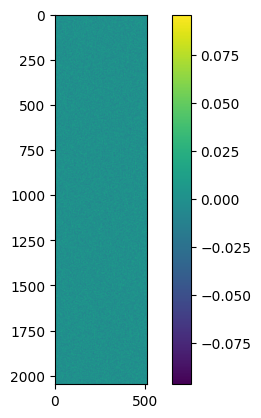

In [6]:
# Now let's take a look at its weights and logits

# Finding the weights
# What's in the state dict?
print(model.state_dict().keys())

# OK, it looks like we can get some mlp weights this way.
# For starters, let's take a look at the weights:
mlp_weights = model.blocks[0].mlp.W_out
imshow(mlp_weights)
plt.colorbar()
plt.show()

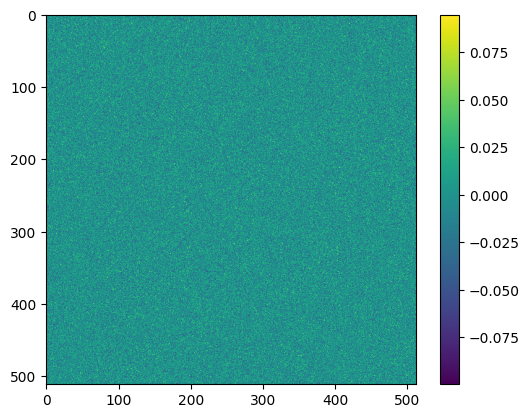

In [7]:
# Attention case:

att_weights = model.blocks[0].attn.W_O
imshow(att_weights.reshape(512, 512))
plt.colorbar()
plt.show()

In [8]:
# Let's try to aggregate some weights across checkpoints
# I'm not sure how many checkpoint indices there are here, so I'm just gonna try 200 and see what happens...

if not os.path.exists("data/mlp_weights_dict.pkl") or not os.path.exists("data/att_weights_dict.pkl"):
    mlp_weights_dict = {}
    att_weights_dict = {}

    for checkpoint_idx in range(200):  # 163 derived from other trials
        try:
            model = HookedTransformer.from_pretrained("NeelNanda/GELU_1L512W_C4_Code", checkpoint_index=checkpoint_idx)
            mlp_weights_dict[checkpoint_idx] = model.blocks[0].mlp.W_out
            att_weights_dict[checkpoint_idx] = model.blocks[0].attn.W_O
        except:
            break

    print(checkpoint_idx)  # 163 - this tells us how many checkpoints there are

    # Save weights just in case
    with open("data/mlp_weights_dict.pkl", "wb") as f:
        pickle.dump(mlp_weights_dict, f)

    with open("data/att_weights_dict.pkl", "wb") as f:
        pickle.dump(att_weights_dict, f)

else:
    with open("data/mlp_weights_dict.pkl", "rb") as f:
        mlp_weights_dict = pickle.load(f)
    with open("data/att_weights_dict.pkl", "rb") as f:
        att_weights_dict = pickle.load(f)

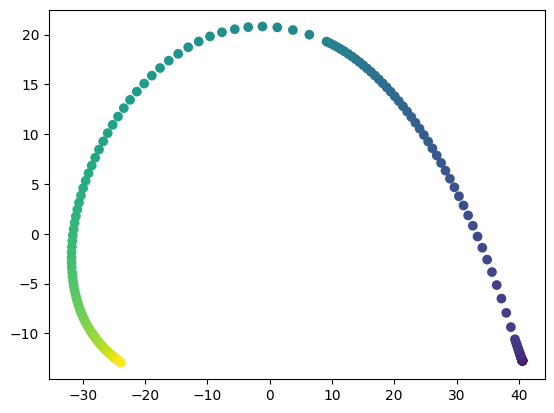

In [9]:
# Basic PCA on the MLP weights:
from sklearn.decomposition import PCA

# Plot PCA for flattened weights
all_flattened_mlp_weights = np.array([mlp_weights_dict[i].flatten() for i in range(163)])
all_flattened_mlp_weights_pca = PCA(n_components=2).fit_transform(all_flattened_mlp_weights)

plt.scatter(
    all_flattened_mlp_weights_pca[:, 0],
    all_flattened_mlp_weights_pca[:, 1],
    c=np.arange(len(all_flattened_mlp_weights_pca)),
)

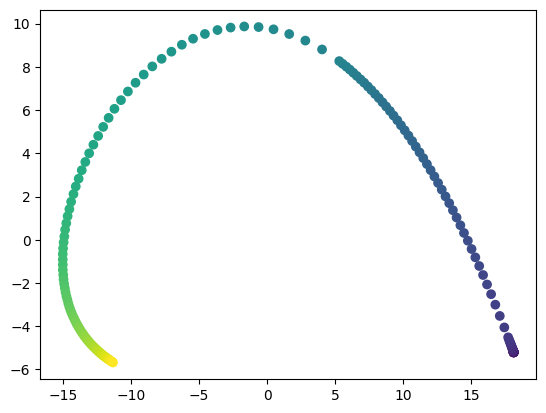

In [10]:
# Same thing for attention

# Plot PCA for flattened weights
all_flattened_att_weights = np.array([att_weights_dict[i].flatten() for i in range(163)])
all_flattened_att_weights_pca = PCA(n_components=2).fit_transform(all_flattened_att_weights)

plt.scatter(
    all_flattened_att_weights_pca[:, 0],
    all_flattened_att_weights_pca[:, 1],
    c=np.arange(len(all_flattened_att_weights_pca)),
)

# Same thing but for modular addition task

Using the notebook here: https://colab.research.google.com/drive/1F6_1_cWXE5M7WocUcpQWp3v8z4b1jL20#scrollTo=P9C8QVqyy0QN

I decided to download the modular addition checkpoints found in https://drive.google.com/file/d/12pmgxpTHLDzSNMbMCuAMXP1lE_XiCQRy/view?usp=sharing

I downloaded them into `data/grokking_addition_full_run.pth`

In [11]:
# For some reason I'm having CUDA compatibility issues with this conda env, so I'll just keep it CPU for now:

full_run_data = torch.load(
    "data/grokking_addition_full_run.pth", map_location="cpu" if not torch.cuda.is_available() else None
)
print(full_run_data.keys())
print(full_run_data["config"])

dict_keys(['train_losses', 'test_losses', 'epochs', 'state_dicts', 'model', 'config'])
{'lr': 0.001, 'p': 113, 'd_model': 128, 'fn_name': 'add', 'frac_train': 0.3, 'num_epochs': 50000, 'save_models': True, 'save_every': 100, 'stopping_thresh': 1e-10, 'seed': 0, 'weight_decay': 1}


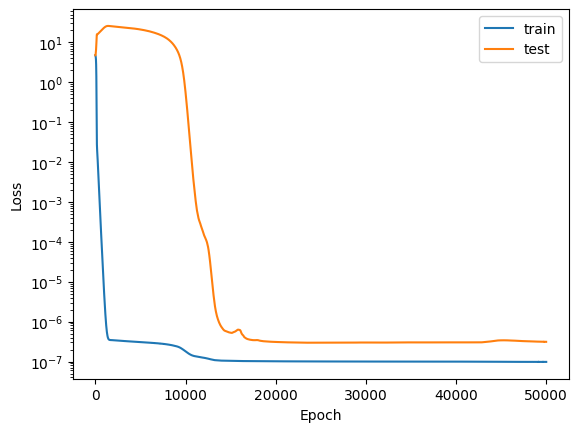

In [12]:
# Let's look at some of the data we have here:

plt.plot(full_run_data["train_losses"], label="train")
plt.plot(np.arange(0, 50000, 10), full_run_data["test_losses"], label="test")
plt.legend()
plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [13]:
# What's going on inside state_dicts

print(full_run_data["state_dicts"][0].keys())

odict_keys(['embed.W_E', 'pos_embed.W_pos', 'blocks.0.attn.W_K', 'blocks.0.attn.W_Q', 'blocks.0.attn.W_V', 'blocks.0.attn.W_O', 'blocks.0.attn.mask', 'blocks.0.mlp.W_in', 'blocks.0.mlp.b_in', 'blocks.0.mlp.W_out', 'blocks.0.mlp.b_out', 'unembed.W_U'])


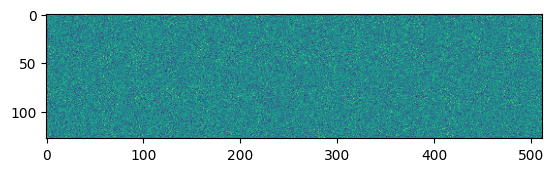

In [14]:
# Let's plot a single weight matrix

plt.imshow(full_run_data["state_dicts"][0]["blocks.0.mlp.W_out"])

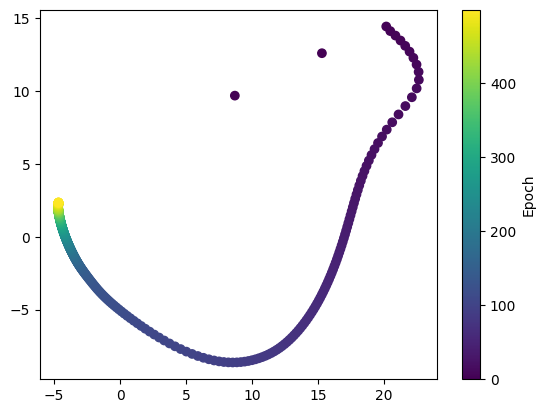

In [15]:
# Now let's do PCA
from sklearn.decomposition import PCA

all_weights = np.array([sd["blocks.0.mlp.W_out"].flatten() for sd in full_run_data["state_dicts"]])

all_weights_pca = PCA(n_components=2).fit_transform(all_weights)

plt.scatter(all_weights_pca[:, 0], all_weights_pca[:, 1], c=np.arange(len(all_weights_pca)))
plt.colorbar(label="Epoch")

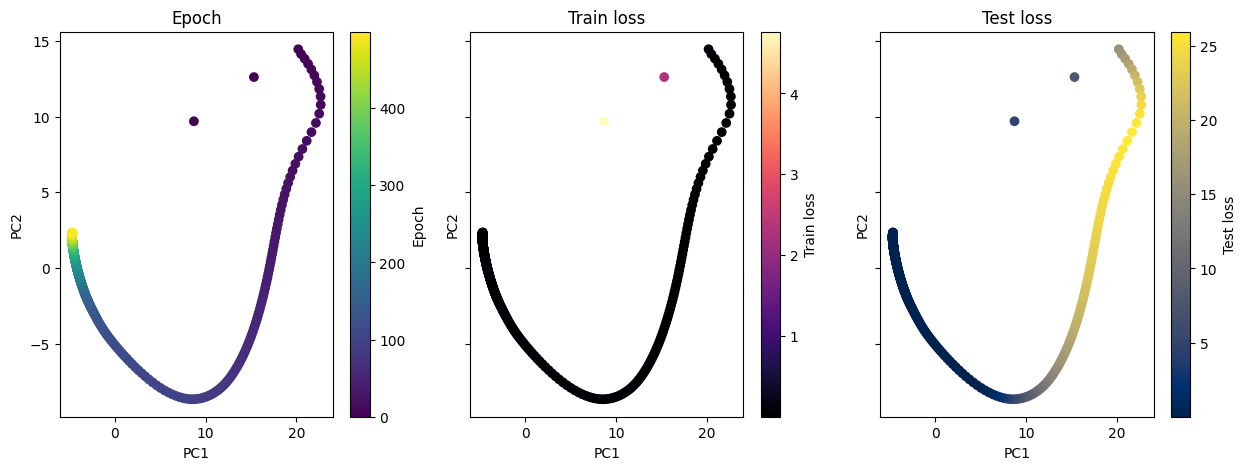

In [16]:
# I want to color this 3 different ways:

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)

for ax, c, name, cmap in zip(
    axs,
    [np.arange(len(all_weights_pca)), full_run_data["train_losses"][::100], full_run_data["test_losses"][::10]],
    ["Epoch", "Train loss", "Test loss"],
    ["viridis", "magma", "cividis"],
):
    ax.scatter(all_weights_pca[:, 0], all_weights_pca[:, 1], c=c, cmap=cmap)
    ax.set_title(name)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    cbar = fig.colorbar(ax.collections[0], ax=ax)
    cbar.set_label(name)

In [17]:
# Copied all_data logits code from example notebook
from src.transformer import Transformer
import torch.nn.functional as F


def cross_entropy_high_precision(logits, labels):
    # Shapes: batch x vocab, batch
    # Cast logits to float64 because log_softmax has a float32 underflow on overly
    # confident data and can only return multiples of 1.2e-7 (the smallest float x
    # such that 1+x is different from 1 in float32). This leads to loss spikes
    # and dodgy gradients
    logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
    prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
    loss = -torch.mean(prediction_logprobs)
    return loss


# Get data
p = full_run_data["config"]["p"]
all_data = torch.tensor([(i, j, p) for i in range(p) for j in range(p)])
labels = torch.tensor([(i + j) % p for i, j, _ in all_data])

# Get logits - set model
# Sorry for all the magic numbers here - I'm just copying the model definition from the example notebook and
# trying to be efficient
model = Transformer(
    num_layers=1,
    d_vocab=p + 1,
    d_model=full_run_data["config"]["d_model"],
    d_mlp=4 * full_run_data["config"]["d_model"],
    d_head=full_run_data["config"]["d_model"] // 4,
    num_heads=4,
    n_ctx=3,
    act_type="ReLU",
    use_cache=False,
    use_ln=False,
)
model.load_state_dict(full_run_data["state_dicts"][400])
original_logits = model(all_data)[:, -1]
# Remove equals sign from output logits
original_logits = original_logits[:, :-1]

# Get loss
original_loss = cross_entropy_high_precision(original_logits, labels)
print(f"Original loss: {original_loss.item()}")  # Should be 2.4e-7

Original loss: 2.4122026455418453e-07


In [18]:
# What happens if we do this for every checkpoint?

if not os.path.exists("data/all_logits.npy"):
    all_logits = []
    for sd in full_run_data["state_dicts"]:
        model.load_state_dict(sd)
        all_logits.append(model(all_data)[:, -1][:, :-1].detach().numpy())
    all_logits = np.array(all_logits)
    np.save("data/all_logits.npy", all_logits)

else:
    all_logits = np.load("data/all_logits.npy")

print(all_logits.shape)

(500, 12769, 113)


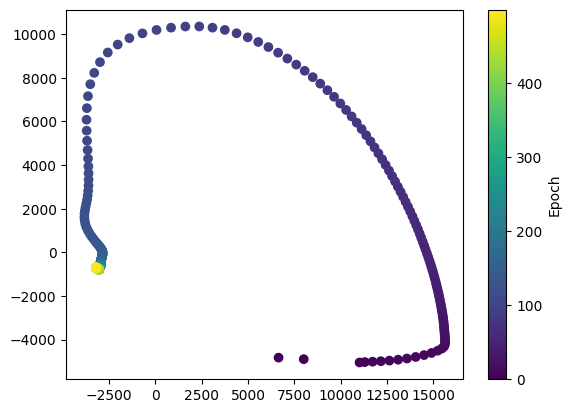

In [19]:
# Now let's do PCA
from sklearn.decomposition import PCA

all_logits_flattened = all_logits.reshape(500, -1)  # number of checkpoints, (data_size * vocab_size)
all_logits_pca = PCA(n_components=2).fit_transform(all_logits_flattened)

plt.scatter(all_logits_pca[:, 0], all_logits_pca[:, 1], c=np.arange(len(all_logits_pca)))
plt.colorbar(label="Epoch")

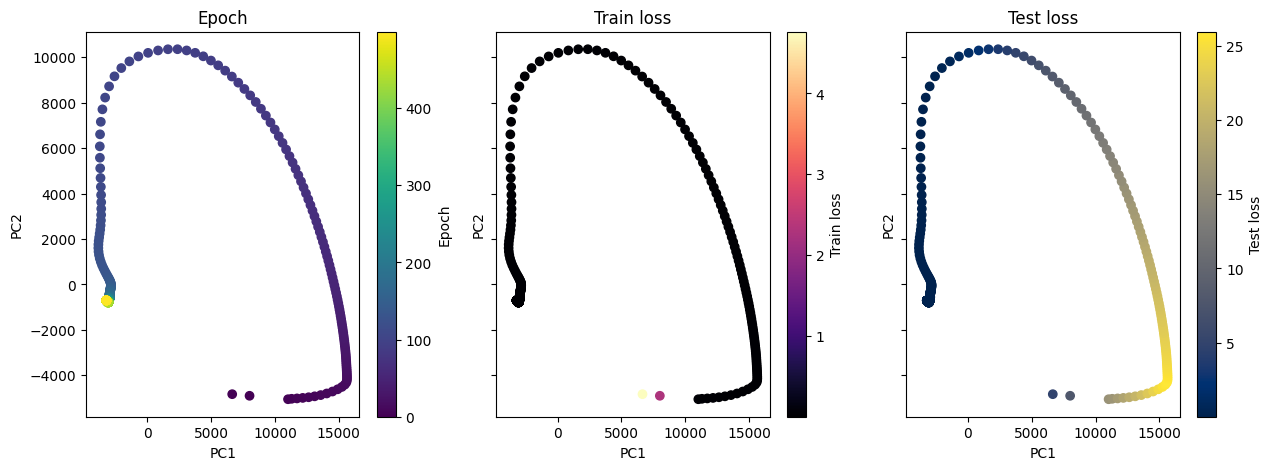

In [20]:
# I want to color this 3 different ways:

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)

for ax, c, name, cmap in zip(
    axs,
    [np.arange(len(all_logits_pca)), full_run_data["train_losses"][::100], full_run_data["test_losses"][::10]],
    ["Epoch", "Train loss", "Test loss"],
    ["viridis", "magma", "cividis"],
):
    ax.scatter(all_logits_pca[:, 0], all_logits_pca[:, 1], c=c, cmap=cmap)
    ax.set_title(name)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    cbar = fig.colorbar(ax.collections[0], ax=ax)
    cbar.set_label(name)

# What causes this?

Some things we might want to do:
* Show what these components are correlated with / interpret the trajectories
* Use trajectories for forecasting grokking

I think the best avenue forward would be to start producing a number of trajectories: first of all, multiple seeds for 
the existing trainings; then, start messing up the grokking:
* Less data
* Mess with the regularization, maybe
* Maybe even directly mess with head formation

Determine whether there are any properties of the (partial) trajectories indicating a phase change


---

Circuits-based analysis ideas:
* We can try activation patching (head-by-head?) to see which logit-PCs end up closest to the grokked regime, but really
this is just reinventing logit attribution

---

Since most of this requires running new experiments, I'm going to briefly look for **leading indicators** instead. The
idea is, can I find something in the weights or logits that shows that the system is about to grok?

In [21]:
# Test indices will come in handy later

test_idx = np.arange(0, 50000, 10)
checkpoint_idx = np.arange(0, 50000, 100)

(500,)


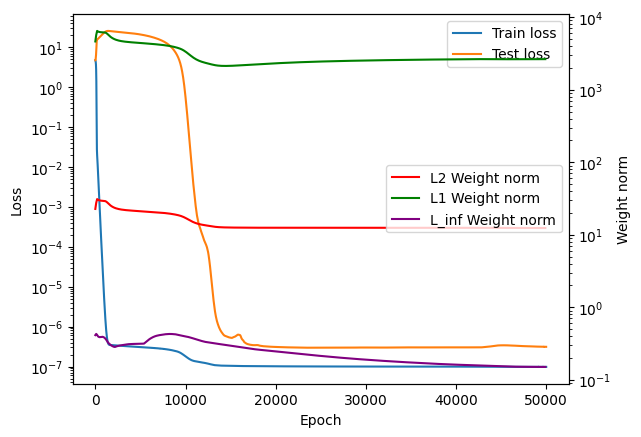

In [22]:
# Norms of weight matrices

weight_norms_l2 = np.linalg.norm(all_weights, axis=1)
weight_norms_l1 = np.linalg.norm(all_weights, axis=1, ord=1)
weight_norms_l_inf = np.linalg.norm(all_weights, axis=1, ord=np.inf)
print(weight_norms_l2.shape)

plt.plot(full_run_data["train_losses"], label="Train loss")
plt.plot(test_idx, full_run_data["test_losses"], label="Test loss")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")

plt.twinx()
plt.plot(checkpoint_idx, weight_norms_l2, label="L2 Weight norm", color="red")
plt.plot(checkpoint_idx, weight_norms_l1, label="L1 Weight norm", color="green")
plt.plot(checkpoint_idx, weight_norms_l_inf, label="L_inf Weight norm", color="purple")
plt.legend(loc="center right")
plt.ylabel("Weight norm")
plt.yscale("log")

This plot is a bit of a mess, but it actually has some interesting properties: the $L_\infty$ norm of the weights
actually goes up after the train loss goes down, but before the test loss goes down. Maybe this is a leading indicator
of grokking?

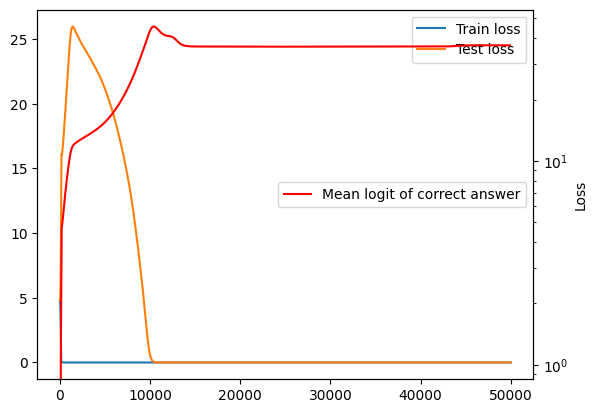

In [62]:
# Logits of correct answer

answer_logits = all_logits[
    np.arange(all_logits.shape[0])[:, None].repeat(all_logits.shape[1], axis=1),
    np.arange(all_logits.shape[1])[None, :].repeat(all_logits.shape[0], axis=0),
    labels,
]

plt.plot(full_run_data["train_losses"], label="Train loss")
plt.plot(test_idx, full_run_data["test_losses"], label="Test loss")
plt.legend()

plt.twinx()
plt.plot(checkpoint_idx, answer_logits.mean(axis=1), label="Mean logit of correct answer", color="red")
plt.yscale("log")
plt.legend(loc="center right")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Here we can additionally see that the logits of the correct answer increase somewhat smoothly before the grokking is 
actually observed in the loss

In [53]:
# For the next couple of plots, we need to actually do PCA for all partial states:

mlp_pcs = []
mlp_eigs = []

for i in tqdm(range(2, len(all_weights))):
    mlp_pca = PCA(n_components=2)
    mlp_pca.fit(all_weights[:i])
    mlp_pcs.append(mlp_pca.components_)
    mlp_eigs.append(mlp_pca.explained_variance_)

  0%|          | 0/498 [00:00<?, ?it/s]

Text(0.5, 0, 'Epoch')

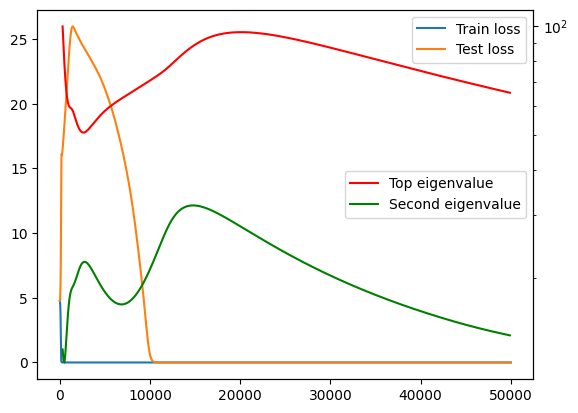

In [63]:
# Top couple eigenvalues over time

plt.plot(full_run_data["train_losses"], label="Train loss")
plt.plot(test_idx, full_run_data["test_losses"], label="Test loss")
plt.legend()

# Index checkpoint_idx[2:] because we need enough data to do PCA in the first place
# The [1:] on the eigenvalues is because the first batch is weird
plt.twinx()
plt.plot(checkpoint_idx[3:], [e[0] for e in mlp_eigs][1:], label="Top eigenvalue", color="red")
plt.plot(checkpoint_idx[3:], [e[1] for e in mlp_eigs][1:], label="Second eigenvalue", color="green")
plt.yscale("log")
plt.legend(loc="center right")
plt.xlabel("Epoch")

  0%|          | 0/498 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Cosine distance matrix for PC2')

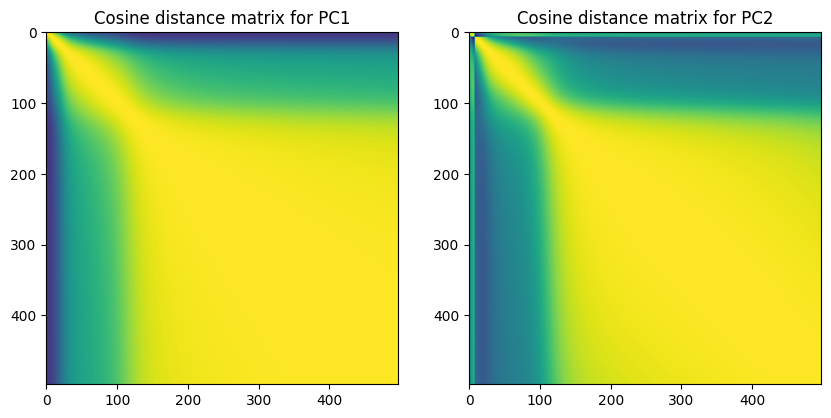

In [60]:
# Cosine distance matrix for PC1 and PC2

cosine_dists_pc1 = np.zeros((len(mlp_pcs), len(mlp_pcs)))
cosine_dists_pc2 = np.zeros((len(mlp_pcs), len(mlp_pcs)))

for i in tqdm(range(len(mlp_pcs))):
    for j in range(len(mlp_pcs)):
        cosine_dists_pc1[i, j] = (
            np.dot(mlp_pcs[i][0], mlp_pcs[j][0]) / np.linalg.norm(mlp_pcs[i][0]) / np.linalg.norm(mlp_pcs[j][0])
        )
        cosine_dists_pc2[i, j] = (
            np.dot(mlp_pcs[i][1], mlp_pcs[j][1]) / np.linalg.norm(mlp_pcs[i][1]) / np.linalg.norm(mlp_pcs[j][1])
        )

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(cosine_dists_pc1)
axs[0].set_title("Cosine distance matrix for PC1")
axs[1].imshow(cosine_dists_pc2)
axs[1].set_title("Cosine distance matrix for PC2")

Based on these plots we can see some dynamics of the ratio of 1st and 2nd eigenvalues of the weight matrix leading up to
grokking: eig1 / eig2 is smallest when memorized, and starts climbing. The 2nd eigenvalue in particular gets really
small right before the system groks...

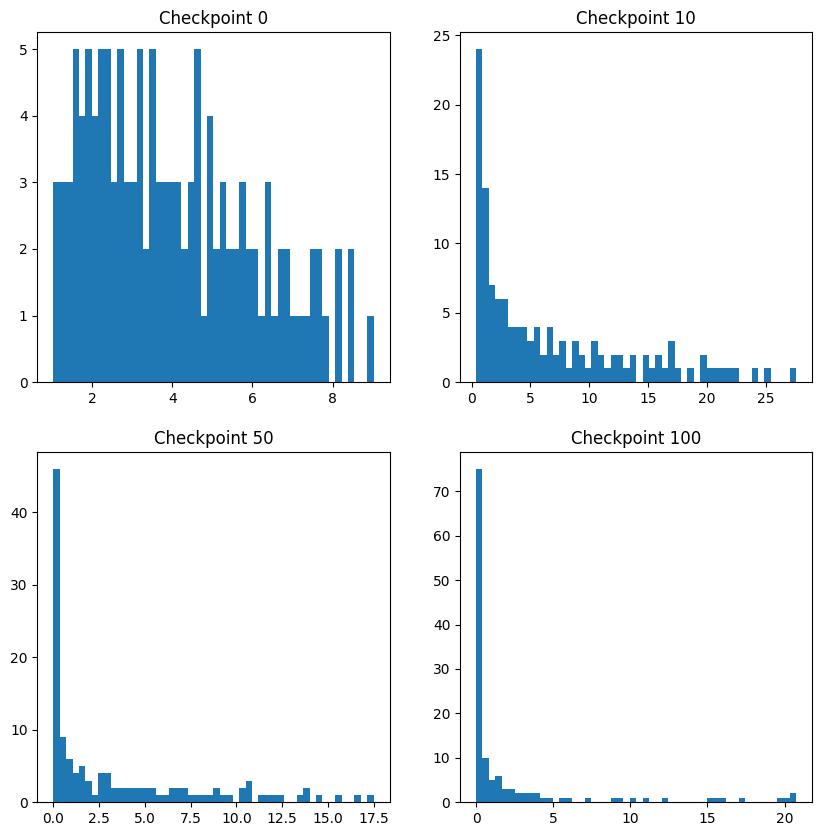

In [67]:
# In general, do we see eigenvalues follow a Wigner semicircle distribution? Maybe there's a transition from Wigner to
# Poisson as training progresses? This would suggest that the matrix ceases to be random as training progresses. But
# is there a leading indicator we can actually draw from this?

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for ax, i in zip(axs.flatten(), [0, 10, 50, 100]):
    sd = full_run_data["state_dicts"][i]
    eigs = np.linalg.eigvals(sd["blocks.0.mlp.W_out"] @ sd["blocks.0.mlp.W_out"].T)
    ax.hist(eigs, bins=50)
    ax.set_title(f"Checkpoint {i}")

Here we see there's a sharpening of the eigenvalues of $WW^T$, which might be something, although I have the least certainty about this conclusion